In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pathlib

%load_ext autoreload
%autoreload 2
%load_ext lab_black

sc.logging.print_header()

scanpy==1.7.0rc2.dev1+g2a123065 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
BASE_PATH = pathlib.Path(
    "/Users/giovanni.palla/dataset_raw_icb/20201214_SquidpyData_giovanni.palla"
)
DATA_PATH = "VisiumFluo"

In [5]:
# read data
sample_id = "V1_Adult_Mouse_Brain_Coronal_Section_2"
adata = sc.read_visium(
    BASE_PATH / DATA_PATH / "2020_10XFluoVisium_MouseBrain2_giovanni.palla",
    count_file=f"{sample_id}_filtered_feature_bc_matrix.h5",
)
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

<AxesSubplot:xlabel='n_genes_by_counts'>

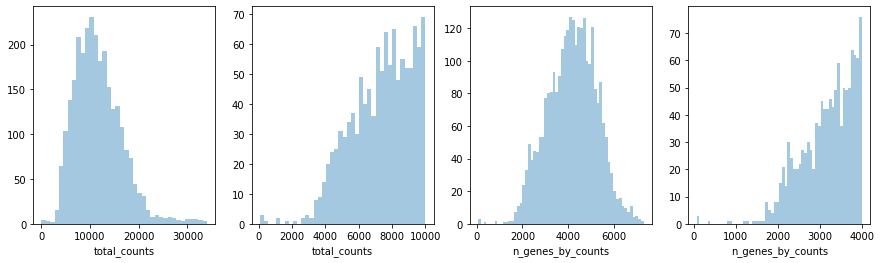

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [6]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=10)

In [7]:
adata.raw = adata
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.7)

/Users/giovanni.palla/Projects/scanpy/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


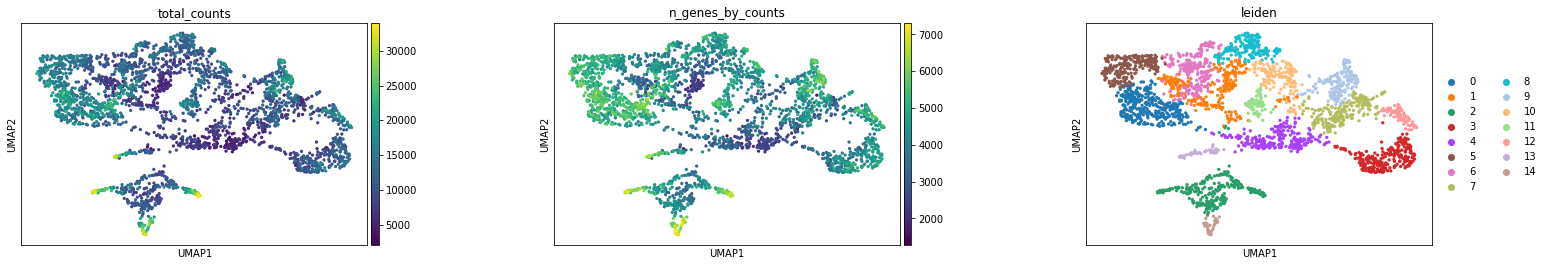

In [8]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4)

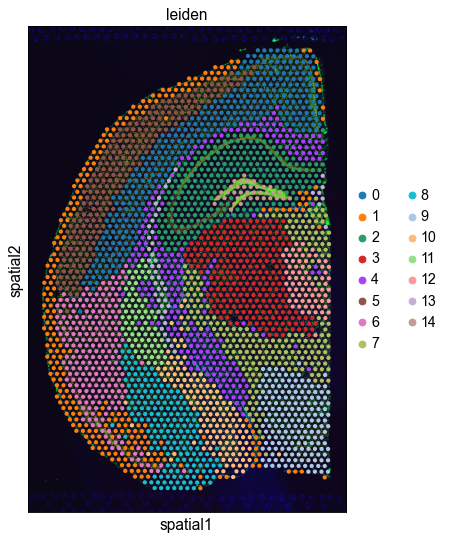

In [9]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color="leiden")

Based on this [paper](https://www.biorxiv.org/content/10.1101/2020.07.24.219758v1.full), the [Allen Brain Atlas](http://mouse.brain-map.org/experiment/thumbnails/100048576?image_type=atlas) and the [mousebrain.org](http://mousebrain.org/genesearch.html) we annotated the clusters as following:

- 0 = Cortex_1
- 1 = Cortex_2
- 2 = Hippocampus
- 3 = Thalamus_1
- 4 = Fiber_tracts
- 5 = Cortex_3
- 6 = Cortex_4
- 7 = Hypothalamus_1
- 8 = Cortex_5
- 9 = Hypothalamus_2
- 10 = Amygdala
- 11 = Striatum
- 12 = Thalamus_2
- 13 = Lateral_ventricle
- 14 = Dentate_gyrus

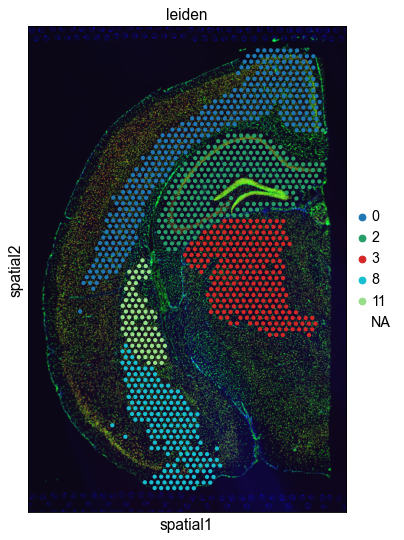

In [10]:
sc.pl.spatial(adata, color="leiden", groups=["0", "2", "3", "8", "11"])

In [11]:
annotation = {
    "0": "Cortex_1",
    "1": "Cortex_2",
    "2": "Hippocampus",
    "3": "Thalamus_1",
    "4": "Fiber_tracts",
    "5": "Cortex_3",
    "6": "Cortex_4",
    "7": "Hypothalamus_1",
    "8": "Cortex_5",
    "9": "Hypothalamus_2",
    "10": "Amygdala",
    "11": "Striatum",
    "12": "Thalamus_2",
    "13": "Lateral_ventricle",
    "14": "Dentate_gyrus",
}

In [12]:
adata.obs["cluster"] = pd.Categorical(adata.obs.leiden.replace(annotation))

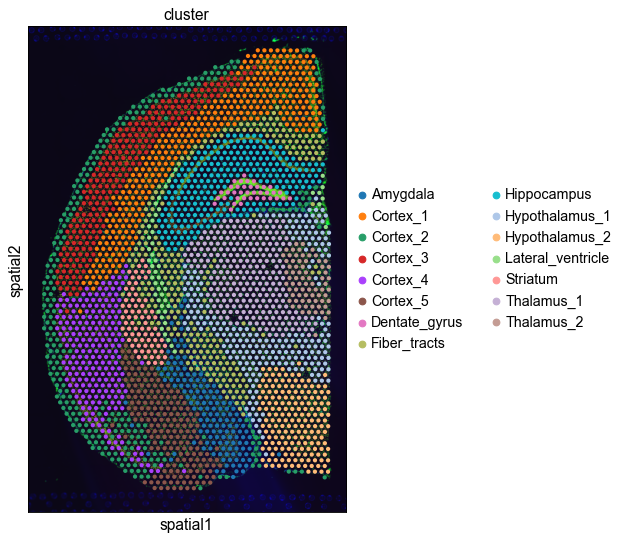

In [13]:
sc.pl.spatial(adata, color="cluster")

In [14]:
adata.write("/Users/giovanni.palla/Datasets/tutorial_data/visium_fluo.h5ad")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [3]:
adata = sc.read("/Users/giovanni.palla/Datasets/tutorial_data/visium_fluo.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 2800 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'